> Chexnet Implemented IN PYTORCH

Imports [Modules required]

In [2]:
import os
import sys
import time
import torch
import shutil
import tarfile
import speedtest
import torchvision
import numpy as np
import urllib.request
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as func
import torch.nn.functional as tfunc
from IPython.display import display
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics._ranking import roc_auc_score
from torch.optim.lr_scheduler import ReduceLROnPlateau


%matplotlib inline

/home/kmit-nvidia/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:


# Create a speedtest object
st = speedtest.Speedtest()

# Get download speed in bits per second and convert to Mbps
download_speed = st.download() / 1000000

# Get upload speed in bits per second and convert to Mbps
upload_speed = st.upload() / 1000000

# Print the results
print(f"Download speed: {download_speed:.2f} Mbps")
print(f"Upload speed: {upload_speed:.2f} Mbps")


Download speed: 11.90 Mbps
Upload speed: 11.93 Mbps


In [4]:
# # Download DATASET required for Chesxnet

#!/usr/bin/env python3
# Download the 56 zip files in Images_png in batches


# URLs for the zip files
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
	'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
	'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
	'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
	'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
	'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
	'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
	'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]

def progress_bar(block_num, block_size, total_size):
    percentage = (block_num * block_size * 100) / total_size
    
    if (int(percentage) in [10 , 25 , 50 , 75 ]):
        print(f"Downloaded {percentage : 2f}% of file")
    

for idx, link in enumerate(links):
    
    fn = 'images_%02d.tar.gz' % (idx+1)
    print('downloading '+fn+' ...')
    urllib.request.urlretrieve(link, fn , reporthook=progress_bar ) 
    
#estimated time in DGX 6*10*12 == 12 hours damn
# About to take lot of time hence runing script as independent File imgdownload.py using SCREEN tool

SyntaxError: invalid syntax (74436458.py, line 36)

In [3]:
#inspecting File Structure
current_path = os.getcwd()
print(current_path)

files = os.listdir('.')
print(files)


/home/kmit-nvidia/jay/Chexnet
['output.log', 'ZIP_DATASET', 'database', 'dataset', 'Test.ipynb', 'm-25012018-123527.pth.tar', '.ipynb_checkpoints', 'imgdownload.py']


In [5]:
for i in os.listdir('.'):
  if i.endswith('tar.gz'):
    print(i)
    with tarfile.open(i, 'r:gz') as tar:tar.extractall(f'database/{i[:-7]}')
    # os.remove(i)

images_11.tar.gz
images_05.tar.gz
images_12.tar.gz
images_07.tar.gz
images_02.tar.gz
images_01.tar.gz
images_10.tar.gz
images_08.tar.gz
images_03.tar.gz
images_06.tar.gz
images_04.tar.gz
images_09.tar.gz


In [8]:
# dataset file structure formation
for i in os.listdir('database'):
    if len(os.listdir(f"database/{i}")) == 0:
        os.rmdir(f"database/{i}")
    # input("hehe")

In [4]:
class DATASET(Dataset):
    def __init__(self , transform=None , Train=False ) -> None:
        
        self.records = []
        self.transform = transform
        
        if not Train:
            path = "dataset/test.txt"
        else:
            path = "TO BE DEFINED"
        
        with open(path , "r") as file:
            # print(len(file.readlines()))
            for i in file.readlines():
                record = i.split()
                item = (record[0] , list(map(int , record[1:])))
                self.records.append(item)
                # print(os.path.exists(f"database/{record[0]}"))
                
                
        
        print("Total number of Imgs" , len(self.records))
    
    def __getitem__(self, index) :
        
        IMG = self.records[index]
        # print(IMG)
        PIL_img = Image.open("database/" +IMG[0]).convert("RGB")
        LABEL_img = torch.FloatTensor( IMG[1])
        if self.transform != None: PIL_img = self.transform(PIL_img)
        
        return PIL_img , LABEL_img
    
    def __len__(self):
        return len(self.records)
        
        
                
        
        

Total number of Imgs 22433


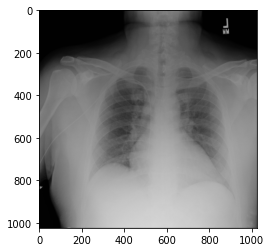

In [5]:
JaysObj = DATASET()
ITEM = JaysObj.__getitem__(0)
plt.imshow(ITEM[0])
plt.show()


In [22]:
class DENSENET(nn.Module):
    
    def __init__(self) -> None:
        super(DENSENET , self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)

        kernelCount = self.densenet121.classifier.in_features
        print(kernelCount)
        self.densenet121.classifier = nn.Sequential(nn.Linear(kernelCount, 14), nn.Sigmoid())

    def forward(self, x):
        return self.densenet121(x)


In [24]:
def computeAUROC (dataGT, dataPRED, classCount):
        
        outAUROC = []
        
        datanpGT = dataGT.cpu().numpy()
        datanpPRED = dataPRED.cpu().numpy()
        
        for i in range(classCount):
            outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
            
        return outAUROC

In [25]:
DISEASES = [ 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
                'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']

cudnn.benchmark = True

model = DENSENET()
device_ids = [0, 1, 2]
model = torch.nn.DataParallel(model , device_ids=device_ids).cuda()
modelCheckpoint = torch.load("models/m-25012018-123527.pth.tar")
model.load_state_dict(modelCheckpoint['state_dict'] , strict=False)
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

IMG_TRANSFORM = transforms.Compose(
    [transforms.Resize(256),
    transforms.TenCrop(224),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops])) ]  
)

DatasetGEN = DATASET(transform=IMG_TRANSFORM)
Dataloader =  DataLoader(dataset=DatasetGEN, batch_size=16, num_workers=8, shuffle=False, pin_memory=True)

outGT = torch.FloatTensor().cuda()
outPRED = torch.FloatTensor().cuda()




/home/kmit-nvidia/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kmit-nvidia/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1024
Total number of Imgs 22433


In [31]:
#predict for single

model.eval()

for i, (input, target) in enumerate(Dataloader):
    # print(f"BATCH {i}")
    target = target.cuda()
    outGT = torch.cat((outGT, target), 0)
    
    bs, n_crops, c, h, w = input.size()
    
    varInput = torch.autograd.Variable(input.view(-1, c, h, w).cuda(), volatile=True)
    
    out = model(varInput)
    outMean = out.view(bs, n_crops, -1).mean(1)
    
    outPRED = torch.cat((outPRED, outMean.data), 0)
    
    
aurocIndividual = computeAUROC(outGT, outPRED, 14)
aurocMean = np.array(aurocIndividual).mean()

print ('AUROC mean ', aurocMean)

for i in range (0, len(aurocIndividual)):
    print (DISEASES[i], ' ', aurocIndividual[i])

torch.Size([16, 10, 3, 224, 224])


In [47]:
model.eval()
SET = DATASET(transform=IMG_TRANSFORM)
ITEM = SET.__getitem__(15)
print(ITEM[1])
input = ITEM[0]
# input.size()
n_crops, c, h, w = input.size()
bs = 16

varInput = torch.autograd.Variable(input)
out = model.forward(varInput)
outMean = out.view( n_crops, -1)

outMean[0] , outMean[1]

Total number of Imgs 22433
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


(tensor([8.1198e-02, 4.8223e-03, 8.1068e-02, 1.8976e-01, 1.3393e-02, 1.2332e-02,
         2.6999e-03, 2.7916e-03, 1.7939e-02, 1.7421e-03, 9.0991e-04, 5.7380e-03,
         1.1354e-02, 9.5703e-05], device='cuda:0', grad_fn=<SelectBackward0>),
 tensor([8.4241e-02, 4.8730e-03, 8.6683e-02, 1.8508e-01, 1.2310e-02, 1.1873e-02,
         2.4036e-03, 2.4535e-03, 1.7361e-02, 2.0344e-03, 1.0040e-03, 5.8637e-03,
         1.1511e-02, 8.7815e-05], device='cuda:0', grad_fn=<SelectBackward0>))